In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [278]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.tsaplots import plot_pacf

In [416]:
df = pd.read_csv('electric_prod.csv', header=0, index_col=0, parse_dates=True)
df.head()

,Value
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [417]:
df.tail()

,Value
Date,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [418]:
df.isnull().sum()

Value    0
dtype: int64

In [419]:
df.shape

(397, 1)

In [420]:
df.describe()

,Value
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


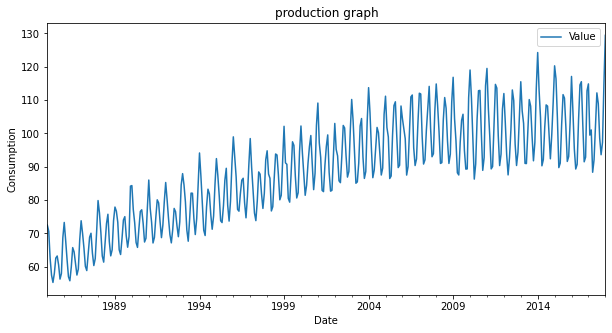

In [421]:
df.plot(figsize=(10,5))
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.show()

#### Seasonal Decomposition

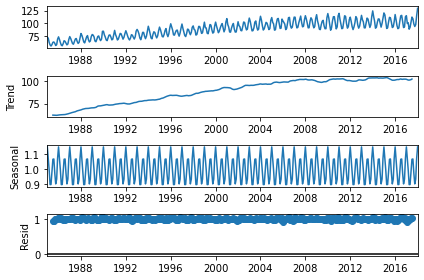

In [422]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

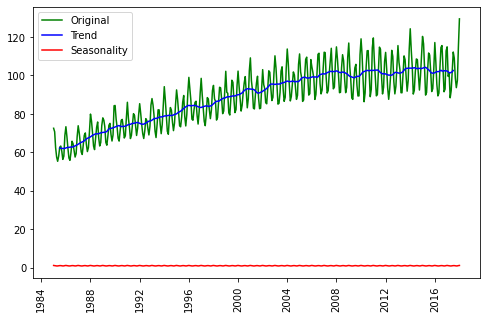

In [423]:
decom = seasonal_decompose(df,model='multiplicative')

observed = decom.observed
trend = decom.trend
seasonal = decom.seasonal
residual = decom.resid

plt.figure(figsize=(8,5))
plt.plot(observed,color='green',label='Original')
plt.plot(trend,color='blue',label='Trend')
plt.plot(seasonal,color='red',label='Seasonality')
# plt.plot(residual,color='black',label='Residual')
plt.xticks(rotation=90)
plt.legend()
plt.show()



### Stationarity Check

In [424]:
from statsmodels.tsa.stattools import adfuller

In [425]:
def adf_test(data):
    res = adfuller(data)
    print('ADF Statistic:',res[0])
    print('p-value:',res[1])
    if res[1]>0.05:
        print('Ho accpeted - Data is not stationary')
    else:
        print('H1 accpeted - Data is stationary')    

In [426]:
adf_test(df)

ADF Statistic: -2.2569903500472397
p-value: 0.18621469116586947
Ho accpeted - Data is not stationary


In [427]:
def plot_roll_mean_std(data,ws):
    rolmean = data.rolling(ws).mean()
    rolstd = data.rolling(ws).std()
    plt.figure(figsize=(8,5))
    plt.plot(data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend()
    plt.title(f'Rolling Mean and Standard Deviation with window size {ws}')
    plt.show()

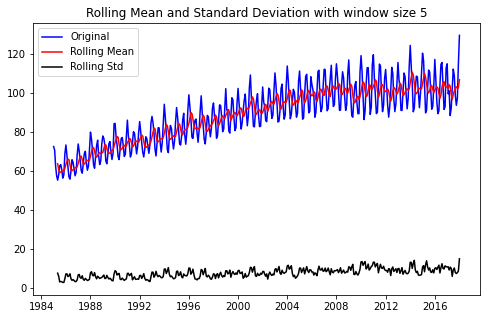

In [428]:
plot_roll_mean_std(df,5)

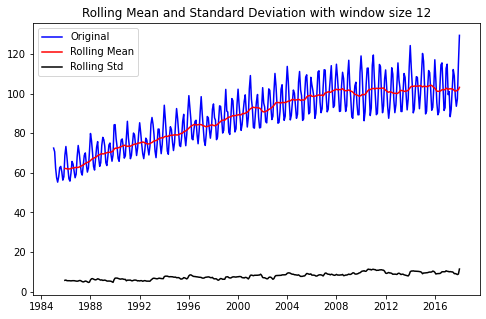

In [429]:
plot_roll_mean_std(df,12)

### Transform Non-Stationary Data to Stationary

#### Differencing

ADF Statistic: -7.104890882267297
p-value: 4.077786565539797e-10
H1 accpeted - Data is stationary


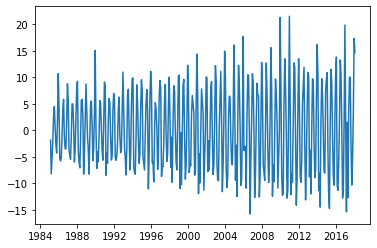

In [430]:
df_diff1 = df.diff(1).dropna() 
adf_test(df_diff1)
plt.plot(df_diff1)
plt.show()

ADF Statistic: -3.1453604281077117
p-value: 0.023373401032986324
H1 accpeted - Data is stationary


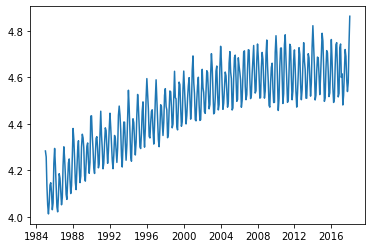

In [431]:
df_log = np.log(df)
adf_test(df_log)
plt.plot(df_log)
plt.show()

### Plot ACF and PACF Functions

In [432]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


In [433]:
def plot_acf_pacf(data,lag_val):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
    plot_acf(data,lags=lag_val,ax=ax1)
    ax1.set_title('Autocorrelation')

    plot_pacf(data,lags=lag_val,ax=ax2)
    ax2.set_title('Partial Autocorrelation')
    plt.show()

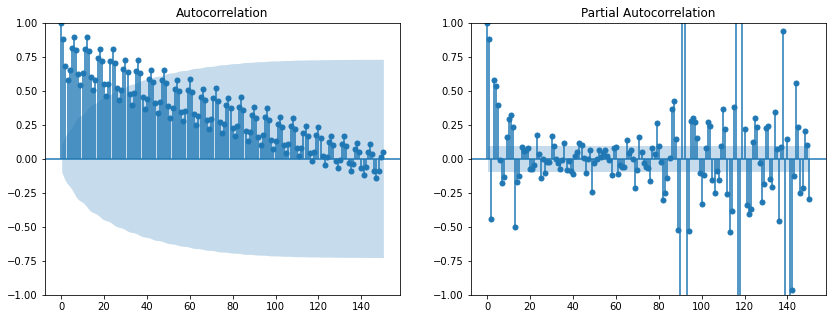

In [434]:
plot_acf_pacf(df_log,150)

### Inference
Since q from ACF is not in the range [0-7] , we are ignoring the df_log method of stationarity conversion.However,log_dofferencing can be explored further

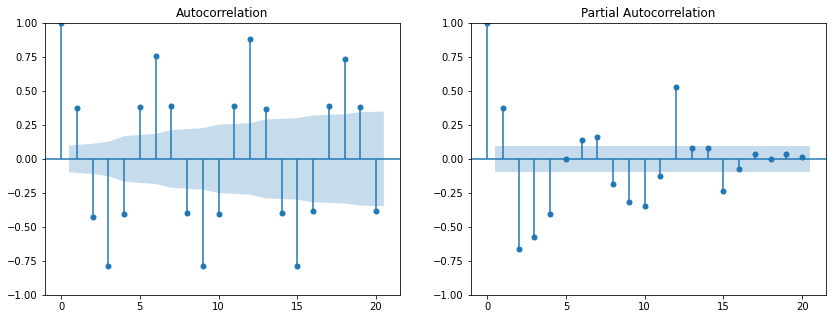

In [435]:
plot_acf_pacf(df_diff1,20)

### Inference
Since p and q from ACF is in the range [0-5] or [0-7] , we can proceed with df_diff1 method of stationarity conversion

### Interpretation - Two different approaches of applying Time Series
1) We apply Time series models on the data that turns out to be stationary (may be after applying log, log_diff,diff etc) based on the p, d and q values obtained from PACF, differencing order and ACF plots respectively. This is the preferred approach. But applying ARMA,AR,MA,ARMA on differtiated data,log_diferentiated data doesnt yield good results generally(exceptions do exist). Also making it diffcult to trace back the actual forecast as the input to the model was differentaied data or log differentiated data. Also log and differentiated data may end up resulting into negative values of AIC and BIC.

2) We actually apply Time series models on the actual data that may or may not be stationary based on assumption that after tha stationarity transformation (may be after applying log, log_diff,diff etc) the p, d and q values obtained from PACF, differencing order and ACF plots respectively would make the data stationary.

### Best Approach (Most appropriate approach)
3) Use pmdarima - It handles the effect of seasonality as well efficiently

### Splitting the data into train and test

In [436]:
train= df[1:281]
test = df[281:397]
print(train.shape)
print(test.shape)

(280, 1)
(116, 1)


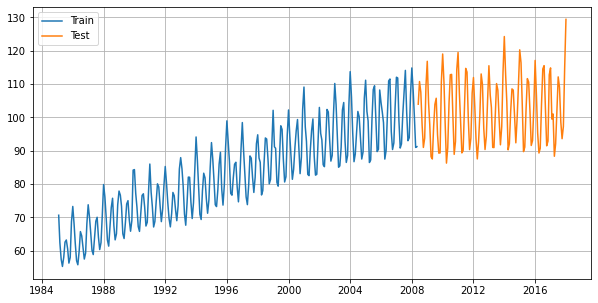

In [437]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.grid()
plt.legend()
plt.show()

In [438]:
print(train.tail(2))
print(test.head(2))
print(test.tail(2))

              Value
Date               
2008-04-01  90.9944
2008-05-01  91.2348
               Value
Date                
2008-06-01  103.9581
2008-07-01  110.7631
               Value
Date                
2017-12-01  114.7212
2018-01-01  129.4048


#### Function for performace metrics

In [439]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [440]:
def test_metrics(test,pred):
    mse = mean_squared_error(test,pred)
    rmse = mean_squared_error(test,pred,squared=False)
    mape = mean_absolute_percentage_error(test,pred)
    return mse,rmse,mape

### Applying different Time Series models on actual data

### Base AR Model(1,0,0)

In [441]:
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [442]:
m1 = ARIMA(train,order=(1,0,0))
ar_m1 = m1.fit()
print(ar_m1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  280
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -927.560
Date:                Sat, 23 Jul 2022   AIC                           1861.120
Time:                        16:16:17   BIC                           1872.024
Sample:                    02-01-1985   HQIC                          1865.494
                         - 05-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.2597      3.513     23.700      0.000      76.374      90.145
ar.L1          0.8765      0.032     27.532      0.000       0.814       0.939
sigma2        43.9173      5.181      8.477      0.0

In [443]:
fcast_m1 = ar_m1.forecast(116)
fcast_m1

2008-06-01    90.249500
2008-07-01    89.385931
2008-08-01    88.629053
2008-09-01    87.965685
2008-10-01    87.384274
                ...    
2017-09-01    83.259701
2017-10-01    83.259700
2017-11-01    83.259700
2017-12-01    83.259700
2018-01-01    83.259700
Freq: MS, Name: predicted_mean, Length: 116, dtype: float64

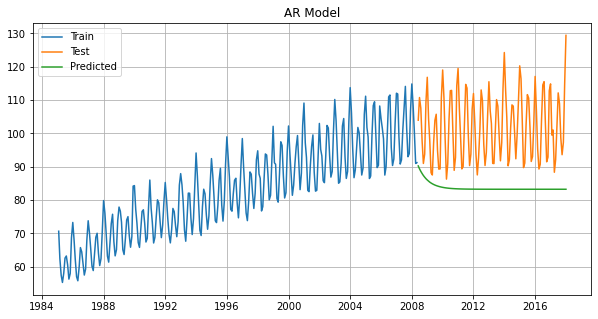

In [444]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m1,label='Predicted')
plt.title('AR Model')
plt.grid()
plt.legend()
plt.show()

In [445]:
aic_m1 = ar_m1.aic
print('AIC',aic_m1)
mse_m1,rmse_m1,mape_m1  = test_metrics(test,fcast_m1)

AIC 1861.1197468755086


In [446]:
m1_res = pd.DataFrame({'Model':'AR(1,0,0)','MSE':mse_m1,'RMSE':rmse_m1,
                       'MAPE':mape_m1,'AIC':aic_m1},index=[0])
m1_res

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",435.965278,20.879782,0.173172,1861.119747


### Base MA Model (0,0,1)

In [447]:
m2 = ARIMA(train,order=(0,0,1))
ar_m2 = m2.fit()
print(ar_m2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  280
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -988.222
Date:                Sat, 23 Jul 2022   AIC                           1982.443
Time:                        16:16:19   BIC                           1993.348
Sample:                    02-01-1985   HQIC                          1986.817
                         - 05-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.3785      0.938     88.906      0.000      81.540      85.217
ma.L1          0.8556      0.034     24.906      0.000       0.788       0.923
sigma2        67.7713      6.982      9.707      0.0

In [448]:
fcast_m2 = ar_m2.forecast(116)
fcast_m2

2008-06-01    88.047116
2008-07-01    83.378533
2008-08-01    83.378533
2008-09-01    83.378533
2008-10-01    83.378533
                ...    
2017-09-01    83.378533
2017-10-01    83.378533
2017-11-01    83.378533
2017-12-01    83.378533
2018-01-01    83.378533
Freq: MS, Name: predicted_mean, Length: 116, dtype: float64

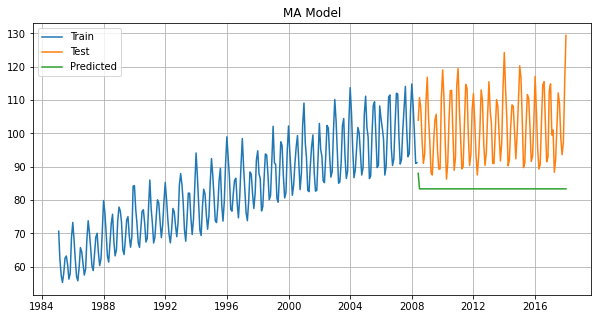

In [449]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m2,label='Predicted')
plt.title('MA Model')
plt.grid()
plt.legend()
plt.show()

In [450]:
aic_m2 = ar_m2.aic
print('AIC',aic_m2)
mse_m2,rmse_m2,mape_m2  = test_metrics(test,fcast_m2)

AIC 1982.4433511349475


In [451]:
m2_res = pd.DataFrame({'Model':'MA(0,0,1)','MSE':mse_m2,'RMSE':rmse_m2,
                       'MAPE':mape_m2,'AIC':aic_m2},index=[1])
m2_res

,Model,MSE,RMSE,MAPE,AIC
1,"MA(0,0,1)",446.470488,21.129848,0.176426,1982.443351


In [452]:
r2 = pd.concat([m1_res,m2_res])
r2

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",435.965278,20.879782,0.173172,1861.119747
1,"MA(0,0,1)",446.470488,21.129848,0.176426,1982.443351


### Base ARMA Model (1,0,1)

In [453]:
m3 = ARIMA(train,order=(1,0,1))
ar_m3 = m3.fit()
print(ar_m3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  280
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -878.506
Date:                Sat, 23 Jul 2022   AIC                           1765.013
Time:                        16:16:22   BIC                           1779.552
Sample:                    02-01-1985   HQIC                          1770.844
                         - 05-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.3780      2.700     30.879      0.000      78.086      88.670
ar.L1          0.7869      0.043     18.101      0.000       0.702       0.872
ma.L1          0.6131      0.051     11.941      0.0

In [454]:
fcast_m3 = ar_m3.forecast(116)
fcast_m3

2008-06-01    92.675787
2008-07-01    90.694872
2008-08-01    89.135997
2008-09-01    87.909245
2008-10-01    86.943857
                ...    
2017-09-01    83.378042
2017-10-01    83.378042
2017-11-01    83.378042
2017-12-01    83.378042
2018-01-01    83.378042
Freq: MS, Name: predicted_mean, Length: 116, dtype: float64

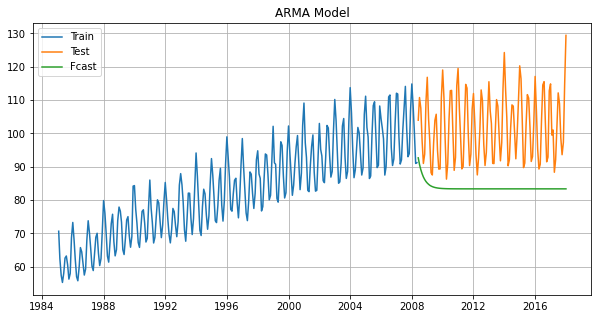

In [455]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m3,label='Fcast')
plt.title('ARMA Model')
plt.grid()
plt.legend()
plt.show()

In [456]:
aic_m3 = ar_m3.aic
print('AIC',aic_m3)
mse_m3,rmse_m3,mape_m3  = test_metrics(test,fcast_m3)

AIC 1765.012651263268


In [457]:
m3_res = pd.DataFrame({'Model':'ARMA(1,0,1)','MSE':mse_m3,'RMSE':rmse_m3,
                       'MAPE':mape_m3,'AIC':aic_m3},index=[2])
m3_res

,Model,MSE,RMSE,MAPE,AIC
2,"ARMA(1,0,1)",435.076016,20.858476,0.173149,1765.012651


In [458]:
r3 = pd.concat([r2,m3_res])
r3

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",435.965278,20.879782,0.173172,1861.119747
1,"MA(0,0,1)",446.470488,21.129848,0.176426,1982.443351
2,"ARMA(1,0,1)",435.076016,20.858476,0.173149,1765.012651


### BASE ARIMA(1,1,1) Model

In [459]:
m4 = ARIMA(train,order=(1,1,1))
ar_m4 = m4.fit()
print(ar_m4.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  280
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -889.817
Date:                Sat, 23 Jul 2022   AIC                           1785.634
Time:                        16:16:42   BIC                           1796.527
Sample:                    02-01-1985   HQIC                          1790.004
                         - 05-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0518      0.108      0.478      0.633      -0.161       0.264
ma.L1          0.5472      0.082      6.678      0.000       0.387       0.708
sigma2        34.4409      3.178     10.837      0.0

In [460]:
fcast_m4 = ar_m4.forecast(116)
fcast_m4

2008-06-01    93.795397
2008-07-01    93.928034
2008-08-01    93.934904
2008-09-01    93.935260
2008-10-01    93.935278
                ...    
2017-09-01    93.935279
2017-10-01    93.935279
2017-11-01    93.935279
2017-12-01    93.935279
2018-01-01    93.935279
Freq: MS, Name: predicted_mean, Length: 116, dtype: float64

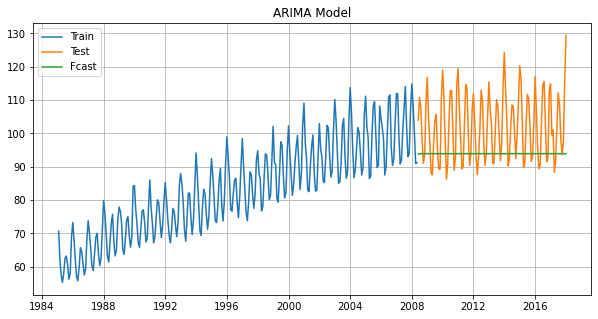

In [461]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m4,label='Fcast')
plt.title('ARIMA Model')
plt.grid()
plt.legend()
plt.show()

In [463]:
aic_m4 = ar_m4.aic
print('AIC',aic_m4)

mse_m4,rmse_m4,mape_m4  = test_metrics(test,fcast_m4)

AIC 1785.633730382901


In [464]:
m4_res = pd.DataFrame({'Model':'ARIMA(1,1,1)','MSE':mse_m4,'RMSE':rmse_m4,
                       'MAPE':mape_m4,'AIC':aic_m4},index=[3])
m4_res

,Model,MSE,RMSE,MAPE,AIC
3,"ARIMA(1,1,1)",162.200321,12.735789,0.093627,1785.63373


In [465]:
r4 = pd.concat([r3,m4_res])
r4

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",435.965278,20.879782,0.173172,1861.119747
1,"MA(0,0,1)",446.470488,21.129848,0.176426,1982.443351
2,"ARMA(1,0,1)",435.076016,20.858476,0.173149,1765.012651
3,"ARIMA(1,1,1)",162.200321,12.735789,0.093627,1785.633730


### ARIMA(2,1,2)

In [466]:
m5 = ARIMA(train,order=(2,1,2))
ar_m5 = m5.fit()
print(ar_m5.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  280
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -720.520
Date:                Sat, 23 Jul 2022   AIC                           1451.040
Time:                        16:16:58   BIC                           1469.196
Sample:                    02-01-1985   HQIC                          1458.323
                         - 05-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0043      0.006    168.555      0.000       0.993       1.016
ar.L2         -0.9956      0.005   -193.429      0.000      -1.006      -0.986
ma.L1         -1.1679      0.027    -43.732      0.0

In [467]:
fcast_m5 = ar_m5.forecast(116)
fcast_m5

2008-06-01    101.861775
2008-07-01    111.730965
2008-08-01    111.062135
2008-09-01    100.564360
2008-10-01     90.687268
                 ...    
2017-09-01    104.402285
2017-10-01     95.252900
2017-11-01     91.983674
2017-12-01     97.809767
2018-01-01    106.915899
Freq: MS, Name: predicted_mean, Length: 116, dtype: float64

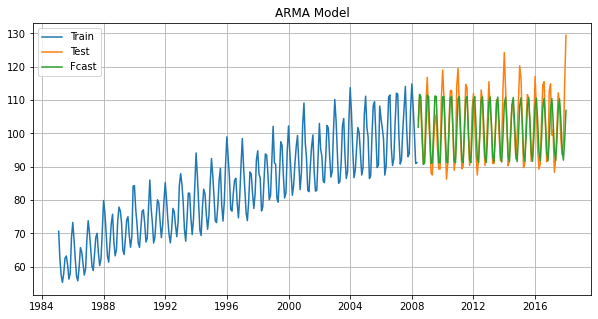

In [468]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m5,label='Fcast')
plt.title('ARMA Model')
plt.grid()
plt.legend()
plt.show()

In [469]:
aic_m5 = ar_m5.aic
print('AIC',aic_m5)

mse_m5,rmse_m5,mape_m5  = test_metrics(test,fcast_m5)

AIC 1451.0401178474913


In [470]:
m5_res = pd.DataFrame({'Model':'ARIMA(2,1,2)','MSE':mse_m5,'RMSE':rmse_m5,
                       'MAPE':mape_m5,'AIC':aic_m5},index=[4])
m5_res

,Model,MSE,RMSE,MAPE,AIC
4,"ARIMA(2,1,2)",33.895395,5.821975,0.041406,1451.040118


In [471]:
r5 = pd.concat([r4,m5_res])
r5

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",435.965278,20.879782,0.173172,1861.119747
1,"MA(0,0,1)",446.470488,21.129848,0.176426,1982.443351
2,"ARMA(1,0,1)",435.076016,20.858476,0.173149,1765.012651
3,"ARIMA(1,1,1)",162.200321,12.735789,0.093627,1785.633730
4,"ARIMA(2,1,2)",33.895395,5.821975,0.041406,1451.040118


### Creating a base arima model function for model fitting ,forecasting and graph plotting

In [472]:
def arima_model(train_data,test_data,p,d,q,fcast_val):
    model = ARIMA(train_data,order=(p,d,q))
    ar_model = model.fit()
    print(ar_model.summary())

    fcast_model = ar_model.forecast(fcast_val)
    fcast_model

    plt.figure(figsize=(10,5))
    plt.plot(train_data,label='Train')
    plt.plot(test_data,label='Test')
    plt.plot(fcast_model,label='Fcast')
#     plt.title('ARMA Model')
    plt.grid()
    plt.legend()
    plt.show()
    return ar_model,fcast_model

### ARIMA (3,1,2) Model

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  280
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -711.986
Date:                Sat, 23 Jul 2022   AIC                           1435.973
Time:                        16:17:16   BIC                           1457.760
Sample:                    02-01-1985   HQIC                          1444.712
                         - 05-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8860      0.056     15.775      0.000       0.776       0.996
ar.L2         -0.8855      0.056    -15.880      0.000      -0.995      -0.776
ar.L3         -0.1141      0.056     -2.039      0.0

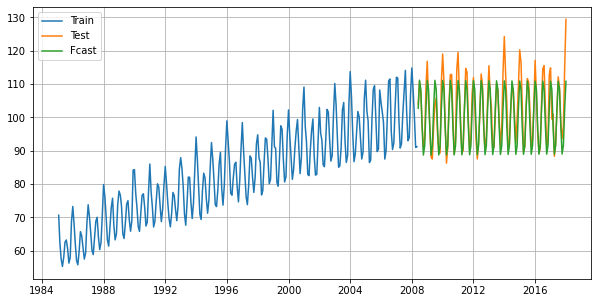

In [474]:
ar_m6,fcast_model = arima_model(train,test,p=3,d=1,q=2,fcast_val=116)

In [475]:
aic_m6 = ar_m6.aic
print('AIC',aic_m6)
mse_m6,rmse_m6,mape_m6  = test_metrics(test,fcast_model)

AIC 1435.972516217158


In [476]:
m6_res = pd.DataFrame({'Model':'ARIMA(3,1,2)','MSE':mse_m6,'RMSE':rmse_m6,
                       'MAPE':mape_m6,'AIC':aic_m6},index=[6])
m6_res

,Model,MSE,RMSE,MAPE,AIC
6,"ARIMA(3,1,2)",21.895306,4.679242,0.031396,1435.972516


In [477]:
r6 = pd.concat([r5,m6_res])
r6

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",435.965278,20.879782,0.173172,1861.119747
1,"MA(0,0,1)",446.470488,21.129848,0.176426,1982.443351
2,"ARMA(1,0,1)",435.076016,20.858476,0.173149,1765.012651
3,"ARIMA(1,1,1)",162.200321,12.735789,0.093627,1785.633730
4,"ARIMA(2,1,2)",33.895395,5.821975,0.041406,1451.040118
6,"ARIMA(3,1,2)",21.895306,4.679242,0.031396,1435.972516


### SES

In [478]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [479]:
alpha=0.3
m7 = ExponentialSmoothing(train)
ses_m7 = m7.fit(smoothing_level=alpha)
print(ses_m7.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Value   No. Observations:                  280
Model:             ExponentialSmoothing   SSE                          16246.445
Optimized:                         True   AIC                           1141.035
Trend:                             None   BIC                           1148.305
Seasonal:                          None   AICC                          1141.181
Seasonal Periods:                  None   Date:                 Sat, 23 Jul 2022
Box-Cox:                          False   Time:                         16:17:44
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3000000                alpha                False
initial_level              63.0874

In [480]:
fcast_m7 = ses_m7.forecast(116)
fcast_m7

2008-06-01    97.643424
2008-07-01    97.643424
2008-08-01    97.643424
2008-09-01    97.643424
2008-10-01    97.643424
                ...    
2017-09-01    97.643424
2017-10-01    97.643424
2017-11-01    97.643424
2017-12-01    97.643424
2018-01-01    97.643424
Freq: MS, Length: 116, dtype: float64

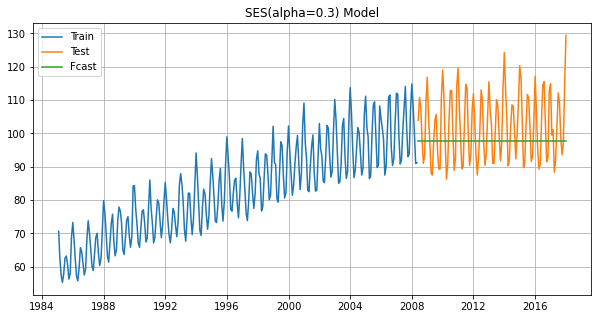

In [482]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m7,label='Fcast')
plt.title('SES(alpha=0.3) Model')
plt.grid()
plt.legend()
plt.show()

In [483]:
aic_m7 = ses_m7.aic
print('AIC',aic_m7)
mse_m7,rmse_m7,mape_m7  = test_metrics(test,fcast_m7)

AIC 1141.0351355411242


In [484]:
m7_res = pd.DataFrame({'Model':'SES(alpha=0.3)','MSE':mse_m7,'RMSE':rmse_m7,
                       'MAPE':mape_m7,'AIC':aic_m7},index=[7])
m7_res


,Model,MSE,RMSE,MAPE,AIC
7,SES(alpha=0.3),114.692633,10.709465,0.083526,1141.035136


In [485]:
r7 = pd.concat([r6,m7_res])
r7

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",435.965278,20.879782,0.173172,1861.119747
1,"MA(0,0,1)",446.470488,21.129848,0.176426,1982.443351
2,"ARMA(1,0,1)",435.076016,20.858476,0.173149,1765.012651
3,"ARIMA(1,1,1)",162.200321,12.735789,0.093627,1785.633730
4,"ARIMA(2,1,2)",33.895395,5.821975,0.041406,1451.040118
6,"ARIMA(3,1,2)",21.895306,4.679242,0.031396,1435.972516
7,SES(alpha=0.3),114.692633,10.709465,0.083526,1141.035136


### DES

In [496]:
alpha=0.5
beta = 0.8
m8 = ExponentialSmoothing(train)
des_m8 = m8.fit(smoothing_level=alpha,smoothing_trend=beta)
print(des_m8.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Value   No. Observations:                  280
Model:             ExponentialSmoothing   SSE                          16641.088
Optimized:                         True   AIC                           1147.755
Trend:                             None   BIC                           1155.025
Seasonal:                          None   AICC                          1147.901
Seasonal Periods:                  None   Date:                 Sat, 23 Jul 2022
Box-Cox:                          False   Time:                         16:19:24
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5000000                alpha                False
initial_level              65.3479

In [497]:
fcast_m8 = ses_m8.forecast(116)
fcast_m8

2008-06-01    97.643424
2008-07-01    97.643424
2008-08-01    97.643424
2008-09-01    97.643424
2008-10-01    97.643424
                ...    
2017-09-01    97.643424
2017-10-01    97.643424
2017-11-01    97.643424
2017-12-01    97.643424
2018-01-01    97.643424
Freq: MS, Length: 116, dtype: float64

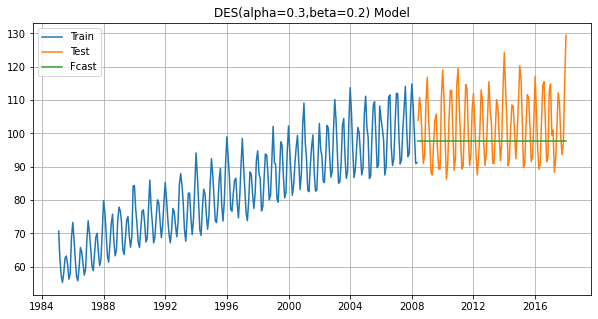

In [498]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m8,label='Fcast')
plt.title('DES(alpha=0.3,beta=0.2) Model')
plt.grid()
plt.legend()
plt.show()

In [500]:
aic_m8 = des_m8.aic
print('AIC',aic_m8)
mse_m8,rmse_m8,mape_m8  = test_metrics(test,fcast_m8)

AIC 1147.7553367526466


In [501]:
m8_res = pd.DataFrame({'Model':'DES(alpha=0.5,beta=0.8)','MSE':mse_m8,'RMSE':rmse_m8,
                       'MAPE':mape_m8,'AIC':aic_m8},index=[8])
m8_res

,Model,MSE,RMSE,MAPE,AIC
8,"DES(alpha=0.5,beta=0.8)",114.692633,10.709465,0.083526,1147.755337


In [502]:
r8 = pd.concat([r7,m8_res])
r8

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",435.965278,20.879782,0.173172,1861.119747
1,"MA(0,0,1)",446.470488,21.129848,0.176426,1982.443351
2,"ARMA(1,0,1)",435.076016,20.858476,0.173149,1765.012651
3,"ARIMA(1,1,1)",162.200321,12.735789,0.093627,1785.633730
4,"ARIMA(2,1,2)",33.895395,5.821975,0.041406,1451.040118
6,"ARIMA(3,1,2)",21.895306,4.679242,0.031396,1435.972516
7,SES(alpha=0.3),114.692633,10.709465,0.083526,1141.035136
8,"DES(alpha=0.5,beta=0.8)",114.692633,10.709465,0.083526,1147.755337


### TES (Holt Winter Method)

In [503]:
alpha= 0.2
beta = 0.4
gamma = 0.3
m9 = ExponentialSmoothing(train)
tes_m9 = m9.fit(smoothing_level=alpha,smoothing_trend=beta,smoothing_seasonal=gamma)
print(tes_m9.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Value   No. Observations:                  280
Model:             ExponentialSmoothing   SSE                          15634.053
Optimized:                         True   AIC                           1130.277
Trend:                             None   BIC                           1137.546
Seasonal:                          None   AICC                          1130.422
Seasonal Periods:                  None   Date:                 Sat, 23 Jul 2022
Box-Cox:                          False   Time:                         16:20:11
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2000000                alpha                False
initial_level              62.3431

In [504]:
fcast_m9 = tes_m9.forecast(116)
fcast_m9

2008-06-01    99.261652
2008-07-01    99.261652
2008-08-01    99.261652
2008-09-01    99.261652
2008-10-01    99.261652
                ...    
2017-09-01    99.261652
2017-10-01    99.261652
2017-11-01    99.261652
2017-12-01    99.261652
2018-01-01    99.261652
Freq: MS, Length: 116, dtype: float64

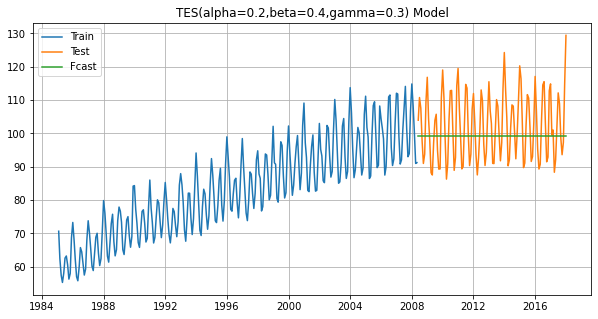

In [506]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m9,label='Fcast')
plt.title('TES(alpha=0.2,beta=0.4,gamma=0.3) Model')
plt.grid()
plt.legend()
plt.show()

In [508]:
aic_m9 = tes_m9.aic
print('AIC',aic_m9)
mse_m9,rmse_m9,mape_m9  = test_metrics(test,fcast_m9)

m9_res = pd.DataFrame({'Model':'TES(alpha=0.2,beta=0.4,gamma=0.3)','MSE':mse_m9,'RMSE':rmse_m9,
                       'MAPE':mape_m9,'AIC':aic_m9},index=[9])
m9_res

AIC 1130.2767850694433


,Model,MSE,RMSE,MAPE,AIC
9,"TES(alpha=0.2,beta=0.4,gamma=0.3)",102.591221,10.128732,0.081174,1130.276785


In [509]:
r9 = pd.concat([r8,m9_res])
r9

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",435.965278,20.879782,0.173172,1861.119747
1,"MA(0,0,1)",446.470488,21.129848,0.176426,1982.443351
2,"ARMA(1,0,1)",435.076016,20.858476,0.173149,1765.012651
3,"ARIMA(1,1,1)",162.200321,12.735789,0.093627,1785.633730
4,"ARIMA(2,1,2)",33.895395,5.821975,0.041406,1451.040118
6,"ARIMA(3,1,2)",21.895306,4.679242,0.031396,1435.972516
7,SES(alpha=0.3),114.692633,10.709465,0.083526,1141.035136
8,"DES(alpha=0.5,beta=0.8)",114.692633,10.709465,0.083526,1147.755337
9,"TES(alpha=0.2,beta=0.4,gamma=0.3)",102.591221,10.128732,0.081174,1130.276785


### pmdarima

In [510]:
import pmdarima as pm

In [512]:
m10 = pm.auto_arima(train,start_p=0,start_q=0,
              test='adf',
              d=None,                     # use adftest to find optimal 'd'        
              max_p=3,max_q=3,max_d=1,
              start_P=0,start_Q=0,
              D=0,                       # enforcing D=0
              max_P=3,max_Q=3,
              seasonal=True,
              trace=True,
              suppress_warnings=True, 
              stepwise=True)  

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2269.665, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1861.120, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1982.443, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3281.296, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1797.542, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1682.350, Time=0.34 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1567.406, Time=0.91 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1760.021, Time=0.30 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1449.584, Time=1.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1748.525, Time=0.74 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1700.607, Time=0.84 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.69 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0] intercept
Total fit time: 6.240 seconds


In [513]:
fcast_m10 = m10.predict(116)
fcast_m10

array([102.08424264, 110.54838605, 108.00674372,  96.84303103,
        88.05102093,  90.24367352, 101.05348453, 109.51038881,
       107.00892216,  95.90038526,  87.13113261,  89.29908172,
       100.06904724, 108.51830797, 106.05646431,  95.00259546,
        86.25578836,  88.39887584,  99.12879865, 107.57002868,
       105.14727276,  94.14758097,  85.42292331,  87.5410064 ,
        98.23070509, 106.66353383, 104.27934707,  93.3333573 ,
        84.630568  ,  86.72351857,  97.37282682, 105.79689946,
       103.45077922,  92.55803172,  83.87684399,  85.94454786,
        96.55331371, 104.96829053, 102.65974939,  91.81979895,
        83.15995965,  85.20231586,  95.77040106, 104.17595674,
       101.90452186,  91.11693718,  82.47820612,  84.49512634,
        95.02240568, 103.41822868, 101.18344114,  90.44780419,
        81.82995354,  83.8213614 ,  94.30772212, 102.69351405,
       100.49492825,  89.81083367,  81.21364735,  83.1794779 ,
        93.62481907, 102.00029409,  99.83747717,  89.20

In [514]:
fcast_m10_res = pd.DataFrame({'Date':test.index,'Pred_price':fcast_m10})
fcast_m10_res.set_index('Date',inplace=True)
fcast_m10_res.head()

,Pred_price
Date,
2008-06-01,102.084243
2008-07-01,110.548386
2008-08-01,108.006744
2008-09-01,96.843031
2008-10-01,88.051021


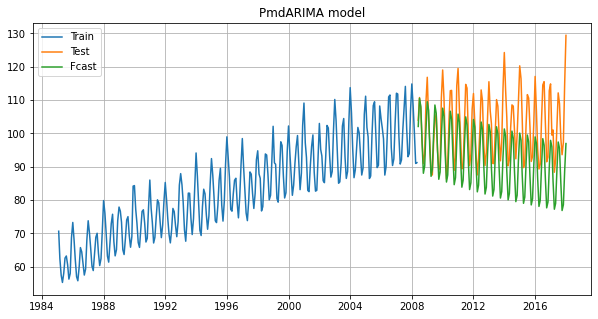

In [515]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m10_res,label='Fcast')
plt.title('PmdARIMA model')
plt.grid()
plt.legend()
plt.show()

In [516]:
aic_m10 = m10.aic()
print('AIC',aic_m10)
mse_m10,rmse_m10,mape_m10  = test_metrics(test,fcast_m10)

AIC 1449.5839622783446


In [517]:
m10_res = pd.DataFrame({'Model':'PmdARIMA','MSE':mse_m10,'RMSE':rmse_m10,
                       'MAPE':mape_m10,'AIC':aic_m10},index=[10])
m10_res

,Model,MSE,RMSE,MAPE,AIC
10,PmdARIMA,135.238448,11.629207,0.09606,1449.583962


In [518]:
r10 = pd.concat([r9,m10_res])
r10

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",435.965278,20.879782,0.173172,1861.119747
1,"MA(0,0,1)",446.470488,21.129848,0.176426,1982.443351
2,"ARMA(1,0,1)",435.076016,20.858476,0.173149,1765.012651
3,"ARIMA(1,1,1)",162.200321,12.735789,0.093627,1785.633730
4,"ARIMA(2,1,2)",33.895395,5.821975,0.041406,1451.040118
6,"ARIMA(3,1,2)",21.895306,4.679242,0.031396,1435.972516
7,SES(alpha=0.3),114.692633,10.709465,0.083526,1141.035136
8,"DES(alpha=0.5,beta=0.8)",114.692633,10.709465,0.083526,1147.755337
9,"TES(alpha=0.2,beta=0.4,gamma=0.3)",102.591221,10.128732,0.081174,1130.276785
10,PmdARIMA,135.238448,11.629207,0.096060,1449.583962


### Inference
<b>1) Based on RMSE or MSE </b>

a) ARIMA(3,1,2) is the most appropriate model(best considering other models)<br>
b) PmdARIMA can also be considered good to go with.

<b>2) Based on AIC</b>

a) TES(alpha=0.2,beta=0.4,gamma=0.3) is the most appropriate model(best considering others).